Homework Group A
## Osama Al Kamel / Mtr Num: 3141575
## Joshua Oldridge / Mtr Num: 3140770
---
# Image Transformers Mini Project
---

## Overview

- [Task Solutions](#Task_Solutions)
- [Implementation Vit](#Implementation-Vit)
  - [Imports](#Imports)
  - [Parameters](#Parameters)
  - [Load data](#Load-data)
  - [Create model](#Create-model)
    - [Embedding layer](#Embedding-layer)
    - [Transformer Encoder](#Transformer-Encoder)
    - [Classifier](#Classifier)
    - [ViT](#Combining-everything-to-a-ViT)
  - [Training](#Training)
  - [Evalute](#Evaluate)
  - [Inference](#inference)
    - [Drawing Examples](#drawing-examples)
    - [Attention Matrix Visualization](#attention-matrix-visualization)
    - [My Interpetation](#myinterheat)
  - [Final Notes](#Final-Notes)

- [Implementation Teacher Model (CNN)](#Implementation-Teacher-Model-(CNN))
  - [Defining a CNN Model](#defining-a-cnn-model)
  - [Training the CNN Model](#training-the-cnn-model)
  - [Evalaute and Compare with ViT](#evaluate-and-comparison-with-vit)
  - [My Interpetation](#t315)
    
- [Implementation DeiT Model and Distilation Loss](#Implementation-deit-model-and-distilation-loss)
  - [Distilation Loss](#distilation-loss)
  - [DeiT Model](#deit-model)
  - [Training The DeiT Model](#training-the-deit-model)
  - [Evalutation and Comparison With The Other Models](#evalutation-and-comparison-with-the-other-models)

- [More Work?](#more-work)  

- [Overall Final Notes](#overall-final-notes)

---

## Task Solutions
- Task 1
    - [Task 1.1](#Task-1:-Inductive-bias-in-transformer-models)
- Task 2
    - [Task 2.1](#task-21-modify-our-vit-implementation-to-output-the-attention-matrix)
    - [Task 2.2](#task-22-write-a-function-that-creates-an-attention-heatmap-for-a-specific-image)
    - [Task 2.3](#task-23-use-the-function-to-visualize-attention-maps-for-example-images)
- Task 3
    - [Task 3.1](#task-31-training-a-teacher-model) 
    - [Task 3.2](#task-32-distillation-loss)
    - [Task 3.3](#task-33-changing-the-vit-architecture-to-allow-distillation)
    - [Task 3.4](#task-34-train-your-own-deit-model)

### Task 1: Inductive bias in transformer models

* What is the biggest weakness of transformer models from a complexity point of view and why can the use of image patches for vision transformers help with that?
<div style="color:lightblue">The problem with complexity is that you need square the number of tokens as connections, so if you have 5 token, then you would need 25 connections, which mean 25 multiplications. Using image patches can reduce the required number of operations, instead of operating on each pixel, which would quickly grow to become too large to compute(for example an image that is 250x250 pixels would need ((250^2)^2) which is too large to compute in current hardware adn would take way too long), we can divide the image into smaller patches and take each patch, so that way we have less operations and we can get the model to run in current hardware in a reasnable amount of time</div>

* What is meant by the term "inductive bias" (sometimes he calls it "inductive prior")?
<div style="color:lightblue">Its the assumption of what solution we need of a network, so its a bias for the model towards solutions that are useful, so instead of telling the model to learn everything from data, we use more specific architecture (for example CNN for images) to guide it towards a desired solution</div>

* What is the interplay between model bias and the amount of available data?
<div style="color:lightblue">The less biases a model is, the more data we need to teach the model. In the case where we have a lot of data, we know that an unbiased model would preform better than a biased model </div>

* If skip connections introduce an inductive bias, why are they needed in the transformer model?
<div style="color:lightblue">Its important for training the transformer as its where the gradient flows back </div>

---

### Task 2.1: Modify our ViT implementation to output the attention matrix 


- Modified the  [VisionTransformer](#t211) , [Encoder](#t212), and [SelfAttention](#t213) classes.<br>
- Added the `return_attention=False` parameter in the [model](#t211)<br>
- Checker the correctness of the dimensions [here](#t214)<br>


### Task 2.2: Write a function that creates an attention heatmap for a specific image

- Made The function [create_attention_heatmap](#t221) That takes in the model, img, and parameters and returns the heatmap. The function:
    - Aggregates the attention matrix based on 'min', 'max, and 'mean'
    - Add residual connection and normalizes
    - Multiplies previous layers into the next
    - Removes values below a threshold
    - Reshapes the heatmap into the same dimensions as the image

### Task 2.3: Use the function to visualize attention maps for example images

- Created the function [display_img_with_heatmap](#t231) that handles the drawing
- Tried different parameters
- Gave Interpretation
---

### Task 3.1: Training a teacher model

- Defined a [CNN model](#t311), which saves the weights of the last epoch
- [Trained](#t312) the model for 10 epochs
- Evluated the model by drawing the [accuracy per epoch graph](#t313) and [displaying some examples](#t314)
- Gave my [interpetation](#t315) as to why the accuracy is different

### Task 3.2: Distillation loss

- Created a [distillation loss function](#t321) that uses hard distilation
    - Takes in the img, teacher model, and the labels
    - Finds the cross entropy loss between the CLS token and the labels
    - Finds the cross entropy loss between the distilation token and the teacher model output
    - Sums the values with weight 0.5 and returns the result

### Task 3.3: Changing the ViT architecture to allow distillation

- Modified the [Embedded layer](#t331) by created the distillation token in the same dimensions as the CLS token and added it to the end of the sequence
- Modified the [Classifier Layer](#t332) to use the distillation token for prediction by adding a fully connected layer that take in the distillation token and outputs a vector with the number of dimensions corresponding to the number of classes, and to return a tuple containing both the CLS and distillation token
- Modified the [DeiT_vit_init_weights function](#t333) to initialize the weights of the previously mentioned addition to the embedded layer


### Task 3.4: Train your own DeiT model

- We [trained](#t341) the model for the same amount of epochs as the rest of the models
- Had to modify the [test loss function](#T342) a bit to account fo the different data structures we were using
- Visualized the [accuracy](#T343) and [loss](#T344) and compared it to the other models,
- displayed the [heatmap](#T345) for different images
- Gave my [interpretation](#T346) 

---

## Implementation Vit
---

### Imports

As always, we start with the imports:

In [1]:
import torch
from torchvision import datasets, transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torchvision.transforms import v2
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import cv2
import time
from tqdm.notebook import trange, tqdm

print(torch.__version__)
#check if cuda is available
cuda_available = torch.cuda.is_available()

#Added device name printing and device variable
device_name = torch.cuda.get_device_name(0)
device = torch.device("cuda" if cuda_available else "cpu")
print(f"cuda available: {cuda_available}, using {device}, GPU name: {device_name}")
use_cuda = cuda_available

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.2.2
cuda available: True, using cuda, GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


### Parameters

In [2]:
# Training parameters
EPOCHS = 25 #Increase epochs to get better results and also to see the change in learning rate from the warmup epochs
WARMUP_EPOCHS = 10
BATCH_SIZE = 128
N_CLASSES = 10
N_WORKERS = 0
LR = 5e-4

# Data parameters
DATASET = 'fmnist'
IMAGE_SIZE = 28
PATCH_SIZE = 4
N_CHANNELS = 1
DATA_PATH = './data/'

# ViT parameters
EMBED_DIM = 64
N_ATTENTION_HEADS = 4
FORWARD_MUL = 2
N_LAYERS = 6
DROPOUT = 0.1
MODEL_PATH = './models'
LOAD_MODEL = False

### Load data

In [3]:
train_transform = transforms.Compose([transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
                              transforms.RandomCrop(IMAGE_SIZE, padding=2), 
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5])])
train = datasets.FashionMNIST(os.path.join(DATA_PATH, DATASET), train=True, download=True, transform=train_transform)

test_transform = transforms.Compose([v2.Resize([IMAGE_SIZE, IMAGE_SIZE]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
test = datasets.FashionMNIST(os.path.join(DATA_PATH, DATASET), train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             num_workers=N_WORKERS,
                                             drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            num_workers=N_WORKERS,
                                            drop_last=False)

Next we can visualize some images together with the corresponding labels:

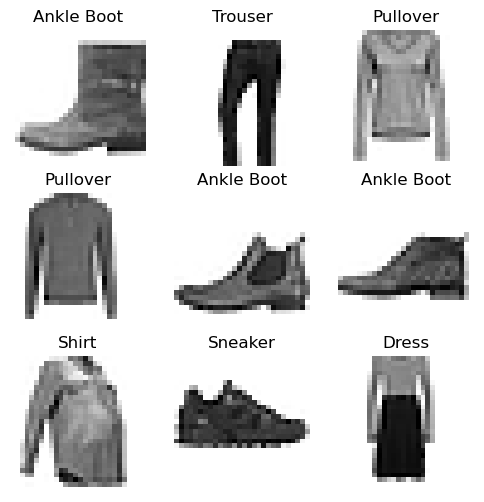

In [4]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (6,6))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train), size = (1,)).item()
    image, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray_r')
plt.show()

### Create model

The model will be the same as the one provided in the material notebook

#### Embedding layer

In [5]:
class EmbedLayer(nn.Module):
    def __init__(self, n_channels, embed_dim, image_size, patch_size, dropout=0.0):
        super().__init__()
        # Convolutional layer to convert image patches to embeddings
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding

        # Classification token, learnable parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        
        # Positional embeddings for each patch + 1 for the classification token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, embed_dim), requires_grad=True)  # Positional Embedding
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Convert image to patch embeddings
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)

        # Flatten the patch embeddings
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)

        # Transpose to match transformer input shape
        x = x.transpose(1, 2)  # B E S -> B S E 

        # Add classification token at the start of each sequence
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        
        # Add positional embeddings
        x = x + self.pos_embedding  # Adding positional embedding
        
        # Apply dropout
        x = self.dropout(x)
        
        return x

#### Transformer Encoder <a id="t213"></a>

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, n_attention_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_attention_heads = n_attention_heads
        self.head_embed_dim = embed_dim // n_attention_heads

        # Linear layers for query, key, and value projections
        self.queries = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads) # Queries projection
        self.keys = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)    # Keys projection
        self.values = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)  # Values projection

        # Output projection layer
        self.out_projection = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        b, s, e = x.shape

        # Project inputs to queries, keys, and values
        xq = self.queries(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, Q, E -> B, Q, H, HE
        xq = xq.transpose(1, 2)  # B, Q, H, HE -> B, H, Q, HE
        xk = self.keys(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, K, E -> B, K, H, HE
        xk = xk.transpose(1, 2)  # B, K, H, HE -> B, H, K, HE
        xv = self.values(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, V, E -> B, V, H, HE
        xv = xv.transpose(1, 2)  # B, V, H, HE -> B, H, V, HE

        # Compute Attention presoftmax values
        xk = xk.transpose(-1, -2)  # B, H, K, HE -> B, H, HE, K
        x_attention = torch.matmul(xq, xk)  # B, H, Q, HE  *  B, H, HE, K -> B, H, Q, K

        # Scale presoftmax values for stability
        x_attention /= float(self.head_embed_dim) ** 0.5

        # Compute Attention Matrix
        x_attention = torch.softmax(x_attention, dim=-1)

        # Compute Attention Values
        x = torch.matmul(x_attention, xv)  # B, H, Q, K * B, H, V, HE -> B, H, Q, HE

        # Format the output
        x = x.transpose(1, 2)  # B, H, Q, HE -> B, Q, H, HE
        x = x.reshape(b, s, e)  # B, Q, H, HE -> B, Q, E
        x = self.out_projection(x)  # B, Q, E -> B, Q, E
        return x, x_attention

<a id="t212"></a>

In [7]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, n_attention_heads, forward_mul, dropout=0.0):
        super().__init__()
        # Layer normalization and self-attention layer
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, n_attention_heads)
        self.dropout1 = nn.Dropout(dropout)

        # Feed-forward network layers
        self.norm2 = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_mul)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_mul, embed_dim)
        self.dropout2 = nn.Dropout(dropout)
        

    def forward(self, x):
        # Apply self-attention with skip connection
        delta_x, x_attention = self.attention(self.norm1(x))
        x = x + self.dropout1(delta_x)

        # Apply feed-forward network with skip connection
        x = x + self.dropout2(self.fc2(self.activation(self.fc1(self.norm2(x)))))
        return x, x_attention


#### Classifier

In [8]:
class Classifier(nn.Module):
    def __init__(self, embed_dim, n_classes):
        super().__init__()
        # Linear layers for classification
        # New architectures skip fc1 and activations and directly apply fc2.
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        # Use only the classification token for prediction
        x = x[:, 0, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

#### Combining everything to a ViT

We can now combine all these components to create the final ViT model:

<a id="t211"></a>

In [9]:
class VisionTransformer(nn.Module):
    def __init__(self, n_channels, embed_dim, n_layers, n_attention_heads, forward_mul, image_size, patch_size, n_classes, dropout=0.1):
        super().__init__()
        # Embedding layer
        self.embedding = EmbedLayer(n_channels, embed_dim, image_size, patch_size, dropout=dropout)

        # Encoder layers
        self.encoder = nn.ModuleList([Encoder(embed_dim, n_attention_heads, forward_mul, dropout=dropout) for _ in range(n_layers)])
        
        # Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier
        self.classifier = Classifier(embed_dim, n_classes)

        # Initialize weights
        self.apply(vit_init_weights)

    #Task 2.1: Added Parameter return_attention
    def forward(self, x, return_attention=False):
        
        # Apply embedding and encoder layers
        x = self.embedding(x)
        for i, block in enumerate(self.encoder):
            x, x_attention = block(x)
            
            if(i > 0):
                #Task 2.1: Appending each attention matrix to each other
                x_attention_return = torch.cat((x_attention_return,x_attention),dim=0)
            else:
                x_attention_return = x_attention
        x = self.norm(x)
        x = self.classifier(x)
        if(return_attention):
            return x, x_attention_return
        return x

#### Initialize Weights 

In [10]:
def vit_init_weights(m): 
    # Initialize weights for Conv2d and Linear layers
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    # Initialize weights for LayerNorm
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    # Initialize weights for EmbedLayer
    elif isinstance(m, EmbedLayer):
        nn.init.trunc_normal_(m.cls_token, mean=0.0, std=0.02)
        nn.init.trunc_normal_(m.pos_embedding, mean=0.0, std=0.02)

### Training

We initialize the model before we start training it

In [11]:
# Initialize model
model = VisionTransformer(n_channels=N_CHANNELS, embed_dim=EMBED_DIM, 
                          n_layers=N_LAYERS, n_attention_heads=N_ATTENTION_HEADS, 
                          forward_mul=FORWARD_MUL, image_size=IMAGE_SIZE, 
                          patch_size=PATCH_SIZE, n_classes=N_CLASSES, dropout=DROPOUT)

In [12]:
# Load model parameters to cuda
model = model.to(device)

In [13]:
# Show model architecture
model

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_af

In [14]:
# Show number of model parameters
params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} learnable parameters")   

Model has 210,122 learnable parameters


In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [299]:
def test_dataset(model,loss_fn,loader):
    # Set Vision Transformer to evaluation mode
    model.eval()

    # Arrays to record all labels and logits
    all_labels = []
    all_logits = []

    # Testing loop
    for (x, y) in loader:
        x = x.cuda()

        # Avoid capturing gradients in evaluation time for faster speed
        with torch.no_grad():
            logits = model(x)

        all_labels.append(y)
        all_logits.append(logits.cpu())

    # Convert all captured variables to torch
    all_labels = torch.cat(all_labels)
    all_logits = torch.cat(all_logits)
    all_pred = all_logits.max(1)[1]
    
    # Compute loss, accuracy and confusion matrix
    loss = loss_fn(all_logits, all_labels).item()
    acc = accuracy_score(y_true=all_labels, y_pred=all_pred)
    cm = confusion_matrix(y_true=all_labels, y_pred=all_pred, labels=range(N_CLASSES))

    return acc, cm, loss

def test(model,loss_fn,train_loader,test_loader):
    # Test using test loader
    acc, cm, loss = test_dataset(model,loss_fn,test_loader)
    print(f"Test acc: {acc:.2%}\tTest loss: {loss:.4f}")
    # Optional: print confusion matrix
    #print(cm)

    return acc, loss

Training for the predefined number of epochs

In [17]:
# Train
iters_per_epoch = len(train_loader)

# Define optimizer for training the model
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# scheduler for linear warmup of lr and then cosine decay
linear_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/WARMUP_EPOCHS, end_factor=1.0, total_iters=WARMUP_EPOCHS-1, last_epoch=-1)
cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-5)

# Variable to capture best test accuracy
best_acc = 0

train_start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    
    start_time = time.time()
    # Set model to training mode
    model.train()

    # Arrays to record epoch loss and accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []

    # Loop on loader
    for i, (x, y) in enumerate(train_loader):

        # Push to GPU
        x, y = x.cuda(), y.cuda()

        # Get output logits from the model 
        logits = model(x)

        # Compute training loss
        loss = loss_fn(logits, y)

        # Updating the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch metrics
        batch_pred = logits.max(1)[1]
        batch_accuracy = (y==batch_pred).float().mean()
        train_epoch_loss += [loss.item()]
        train_epoch_accuracy += [batch_accuracy.item()]

        # Log training progress
        if i % 50 == 0 or i == (iters_per_epoch - 1):
            print(f'Ep: {epoch+1}/{EPOCHS}\tIt: {i+1}/{iters_per_epoch}\tbatch_loss: {loss:.4f}\tbatch_accuracy: {batch_accuracy:.2%}')

    end_time = time.time()

    # Print elapsed time for the epoch
    print(f"Training time for epoch {epoch} in minutes: {(end_time - start_time) / 60:.2f}")

    # Print train acc and loss
    print('------------')
    print(f"Train acc: {sum(train_epoch_accuracy)/iters_per_epoch:.2%}\tTrain loss: {sum(train_epoch_loss)/iters_per_epoch:.4f}")
    
    # Test the test set after every epoch
    test_acc, test_loss = test(model,loss_fn,train_loader,test_loader)
    
    # Capture best test accuracy
    best_acc = max(test_acc, best_acc)
    print(f"Best test acc: {best_acc:.2%}")

    # Save model if accuracy improves
    if test_acc >= best_acc:
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, "ViT_model.pt"))
        print('New model saved!\n')
    
    # Update learning rate using schedulers
    if epoch < WARMUP_EPOCHS:
        linear_warmup.step()
    else:
        cos_decay.step()

    # Update training progression metric arrays
    train_losses += [sum(train_epoch_loss)/iters_per_epoch]
    test_losses += [test_loss]
    train_accuracies += [sum(train_epoch_accuracy)/iters_per_epoch]
    test_accuracies += [test_acc]

train_end_time = time.time()

# overall training time
print(f"Overall training time in minutes: {(train_end_time - train_start_time) / 60:.2f} minutes on {device} for {EPOCHS} epochs")

Ep: 1/25	It: 1/468	batch_loss: 2.3007	batch_accuracy: 13.28%
Ep: 1/25	It: 51/468	batch_loss: 2.2472	batch_accuracy: 16.41%
Ep: 1/25	It: 101/468	batch_loss: 2.1590	batch_accuracy: 18.75%
Ep: 1/25	It: 151/468	batch_loss: 2.0691	batch_accuracy: 25.78%
Ep: 1/25	It: 201/468	batch_loss: 2.0034	batch_accuracy: 21.09%
Ep: 1/25	It: 251/468	batch_loss: 1.9073	batch_accuracy: 24.22%
Ep: 1/25	It: 301/468	batch_loss: 1.9407	batch_accuracy: 27.34%
Ep: 1/25	It: 351/468	batch_loss: 1.8182	batch_accuracy: 29.69%
Ep: 1/25	It: 401/468	batch_loss: 1.8606	batch_accuracy: 16.41%
Ep: 1/25	It: 451/468	batch_loss: 1.7927	batch_accuracy: 25.78%
Ep: 1/25	It: 468/468	batch_loss: 1.8727	batch_accuracy: 21.88%
Training time for epoch 0 in minutes: 0.58
------------
Train acc: 24.01%	Train loss: 1.9987
Test acc: 26.21%	Test loss: 1.8146
Best test acc: 26.21%
New model saved!

Ep: 2/25	It: 1/468	batch_loss: 1.7759	batch_accuracy: 28.12%
Ep: 2/25	It: 51/468	batch_loss: 1.7722	batch_accuracy: 32.03%
Ep: 2/25	It: 101/46

In [18]:
#store the history here for later comparisons
vit_history = {"train" : {"loss" : train_losses, "accuracy" : train_accuracies},
               "test" : {"loss" : test_losses, "accuracy" : test_accuracies}}

### Evaluate

We can now visualize the progression of loss and accuracy values for training and test data during the training process:

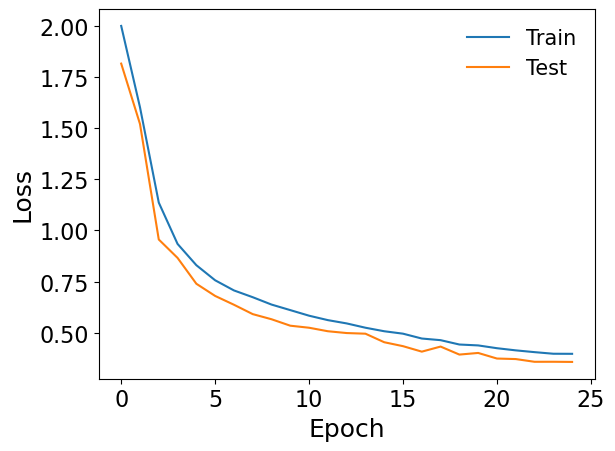

In [19]:
# Plot graph of loss values
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')

plt.ylabel('Loss', fontsize = 18)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(fontsize=16)
plt.legend(fontsize=15, frameon=False)

plt.show()

<div style='color:lightblue'> The model does learn relatively quick and reaches a quite a low loss, the decrease in loss is decreasing, so while there might be some benefit in more epochs, it will be very minimal and take a lot more epochs for more a noticeable decrease

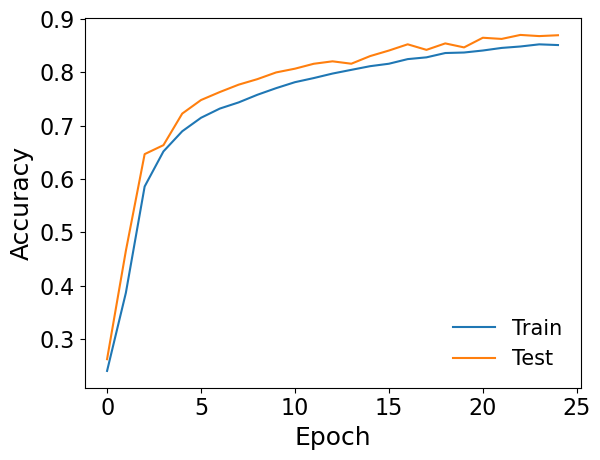

In [21]:
# Plot graph of accuracies
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')

plt.ylabel('Accuracy', fontsize = 18)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(fontsize=16)
plt.legend(fontsize=15, frameon=False)

plt.show()

Same thing for the accuracy, which seems to have platued around 85% accuracy 
<br><br>
The model's accuracy is pretty good for such a small dataset and relatively few epochs. I increased the epochs compared to the original training in the material notebook just to see the difference in results, and it seem <br>
*Overall, we are happy with the model's accuracy* 

## Inference

In [22]:
# function for predicting the class for a given batch by a trained model
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()

First, we make sure that we are using the best performing model so far. In contrast to what we did in connection with Object detection, where we saved the model as such, here we only saved its `state_dict`, so we have to instantiate the model first and then load the `state_dict` again:

In [23]:
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "ViT_model.pt")))
model.to(device)

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_af

Let's start by obtaining the predictions for the 16 images of the first batch of the test set:

In [24]:
offset = 42
# test on images offset to offset+16 of the first set
batch_test = next(iter(test_loader))

preds, _ = predict_batch(model, batch_test[0][offset:offset+16], binary=False)
print(f'Predictions:\t\t {preds}')
print(f'Labels (ground truth):\t {batch_test[1][offset:offset+16]}')

Predictions:		 tensor([6, 9, 6, 7, 2, 1, 4, 6, 4, 2, 5, 8, 2, 2, 8, 4])
Labels (ground truth):	 tensor([3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4])


<div style="color:lightblue">Lets also test the shape of the Attention matrix for one image </div>
<a id="t214"></a>



In [25]:
model.eval()
with torch.no_grad():
    batch = batch_test[0][0:1]
    batch = batch.to(device)
    output, x_attention = model(batch, return_attention=True)
    print(f"The shape of the output tesnor is {output.shape}, and the shape of the attention matrix is {x_attention.shape}")

The shape of the output tesnor is torch.Size([1, 10]), and the shape of the attention matrix is torch.Size([6, 4, 50, 50])


<div style="color:lightblue">The dimesntions seem correct, so lets move one to drawing the heatmap

### Drawing Examples

Now, let's visually check how well our model is doing:

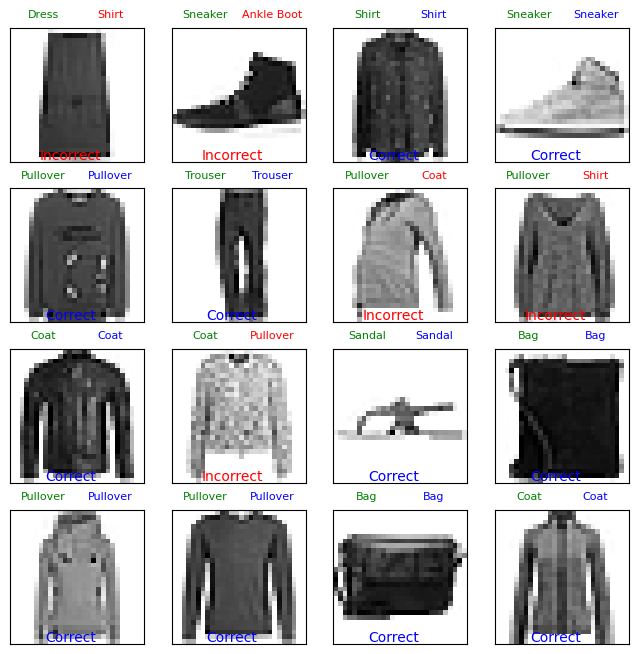

In [26]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        pred = preds[i]
        label = batch_test[1][offset+i]
        pred_txt = labels_map[int(pred)]
        label_txt = labels_map[int(label)]
        
        correct = pred == label
        ax = fig.add_subplot(4, 4, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][offset+i].view(28, 28)
        ax.imshow(img, cmap='gray_r');
        ax.text(0.25, 1.1, '{}'.format(label_txt), 
                size=8, color='green',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.75, 1.1, '{}'.format(pred_txt), 
                size=8, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.45, 0.05, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=10, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)

plt.show()

**Some Interpretation**<br><br>
Overall good predictions, seem to struggle with some of them, the second prediction is an understandable error, s sneaker and ankle boots would look similar at such a low resolution, but for some of them, the error are less forgivable, this could be to the low resolution of images and the relatively small model and small dataset, as transformer models shine when there is a lot of training data

### Attention Matrix Visualization

We define a function that returns a heatmap based on the attention matrix that is passed through <a id="t221"></a> (THis code was mainly based on the code from the first source in the miniproject notebook Task 2)

In [180]:
#Returns a heatmap for a specifice layer
def create_attention_heatmap(x_attentions, aggregate='mean', discard_ratio=0.9, layer=5):
    joint_attentions =torch.empty(6,50,50)
    joint_attentions = joint_attentions.to(device)
    for i, x_attention in enumerate(x_attentions):
        with torch.no_grad():
            x_attention
            
            #Aggregate
            match aggregate:   
                case 'min':
                    x_attention = torch.min(x_attention, dim=0).values
                case 'max':
                    x_attention = torch.max(x_attention, dim=0).values
                case 'mean':
                    x_attention = torch.mean(x_attention, dim=0)
                case _:
                    x_attention = torch.mean(x_attention, dim=0)
                
            discard_attentions = x_attention

            #Add residual connections
            I = torch.eye(discard_attentions.size(1))
            I = I.to(device)
            
            #Normalize
            discard_attentions = discard_attentions + I
            discard_attentions = discard_attentions / discard_attentions.sum(dim=-1).unsqueeze(-1)
            
            
            #Multiply previous layers
            if i == 0:
                joint_attentions[i] = discard_attentions
            else:
                joint_attentions[i] = torch.matmul(discard_attentions, joint_attentions[i-1])

    #Choose layer          
    joint_attentions_layer = joint_attentions[layer]
    
    joint_attentions_layer = joint_attentions_layer[0, 1:]
    joint_attentions_layer = joint_attentions_layer.view(7,7)
    
    #Remove values below threshold
    threshold_value = torch.quantile(joint_attentions_layer, discard_ratio)
    joint_attentions_layer[joint_attentions_layer < threshold_value] = 0
    
    #Reshape into image size
    heatmap = F.interpolate(joint_attentions_layer.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()

    return heatmap

Function to handel drawing <a id="t231"></a>

In [28]:
def display_img_with_heatmap(model,img_to_dis, aggregate='mean', discard_ratio=0.9, layers=6):
    with torch.no_grad():
        img_to_dis = img_to_dis.to(device)
        output, x_attention = model(img_to_dis, return_attention=True)
    
    fig, axs = plt.subplots(1, layers + 1, figsize=(15, 5))
        
    # Display original image
    axs[0].imshow(img[0][0], cmap="gray")
    axs[0].set_title('Original Image')
    axs[0].axis('off')
        
    # Display heatmaps for each layer
    for layer in range(layers):
        heatmap = create_attention_heatmap(x_attention, aggregate=aggregate, discard_ratio=discard_ratio, layer=layer)
        axs[layer + 1].imshow(heatmap.cpu().numpy(), cmap='viridis')
        axs[layer + 1].set_title(f'Layer {layer}')
        axs[layer + 1].axis('off')
        
    plt.tight_layout()
    plt.show()



Now to visualize the attention maps <a id="t221"></a>


In [195]:
batch_test = next(iter(test_loader))
img = batch_test[0][125:126]

We can try some initial parameters, we cant try discard ration 0.5 and aggregate mean, while displaying all layers<a id="t222"></a>

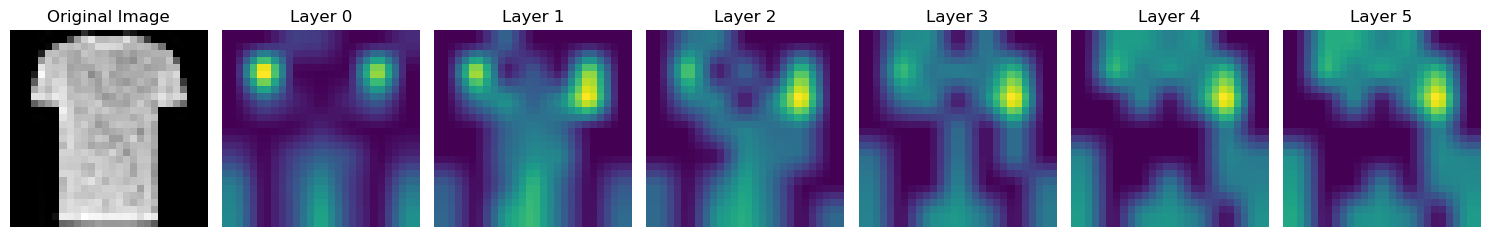

In [202]:
display_img_with_heatmap(model, img, discard_ratio=0.5, aggregate='mean')

**My Interpatation** and tinkering <a id="myinterheat"> </a><br>
Ohh, that looks a bit wrong the first layer seems correct, but it get more weird as we go down the layers<br>Lets try using Max

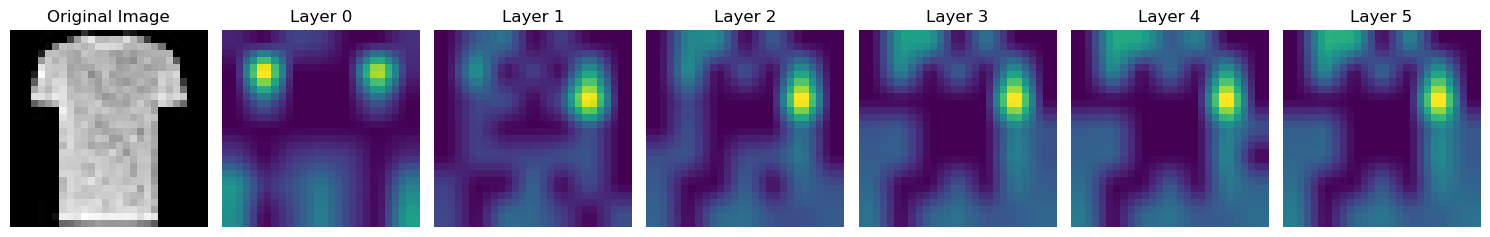

In [206]:
display_img_with_heatmap(model, img, discard_ratio=0.5, aggregate='max')

Ye we have the same problem. lets try min

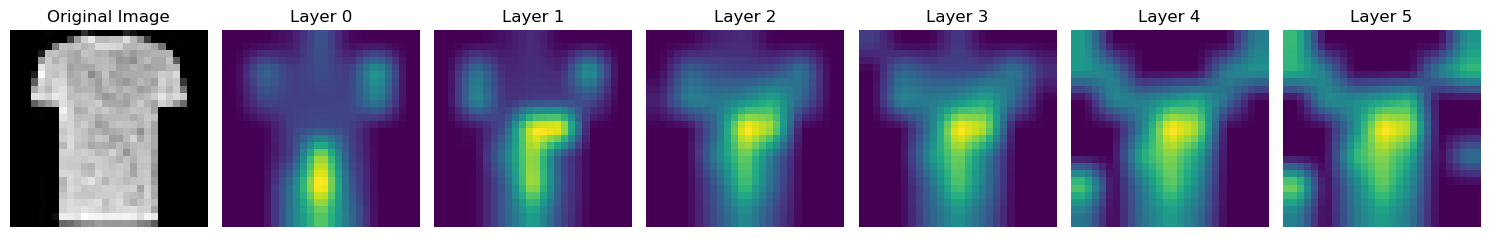

In [207]:
display_img_with_heatmap(model, img, discard_ratio=0.5, aggregate='min')

This looks better, the heatmap shows that the model is more focused on the middle of the image, which makes sense as that is where the shirt is, also the shape of the heatmap follows the outline of the shirt, atleast in the first layers, then it becomes more general, as the network takes a more general look on the image <br> Lets try different discard ratios

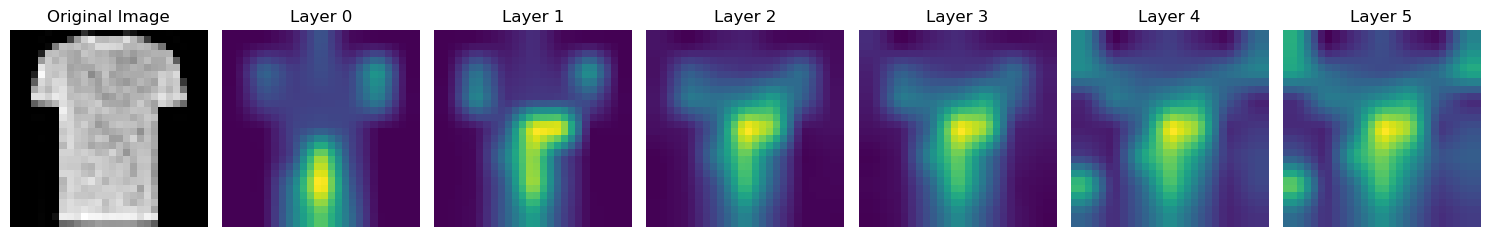

In [208]:
display_img_with_heatmap(model, img, discard_ratio=0.0, aggregate='min')

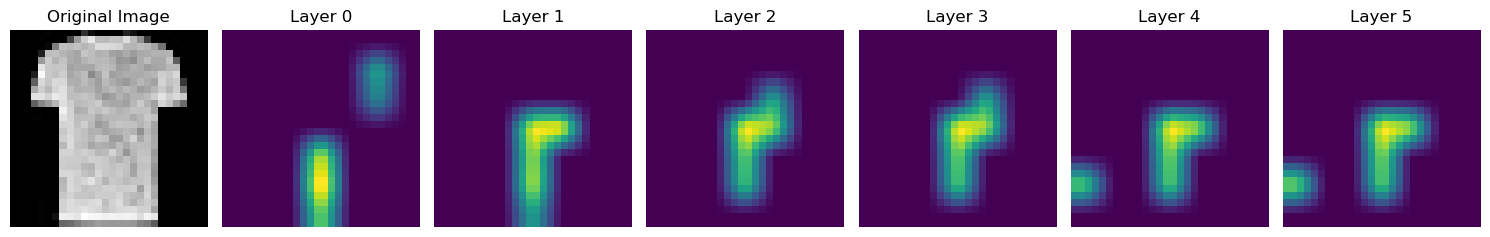

In [209]:
display_img_with_heatmap(model, img, discard_ratio=0.9, aggregate='min')

Ye, for the 0.0 ratio, the heatmap shows alot of effect on kinda irrelevant areas, so it would not make sense to show these as it would not make for a good visualization<br> While the hight discard ratio is too high, it filters too much and we cannot see much of the focus areas, except the middle, which makes sense for it to be the highest attention area as it is where the center of the shirt is, but this is also not that good of a visualization as we loos alot of the detail<br> we can try reducing the discard a bit

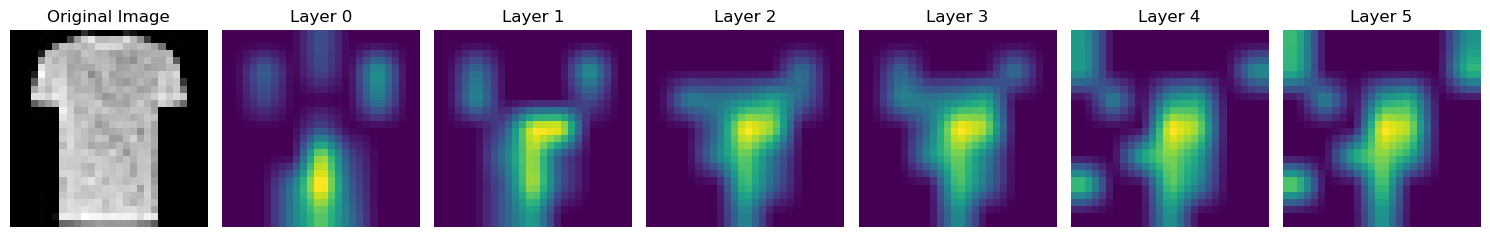

In [210]:
display_img_with_heatmap(model, img, discard_ratio=0.7, aggregate='min')

Ye look weird, lets try a lower value

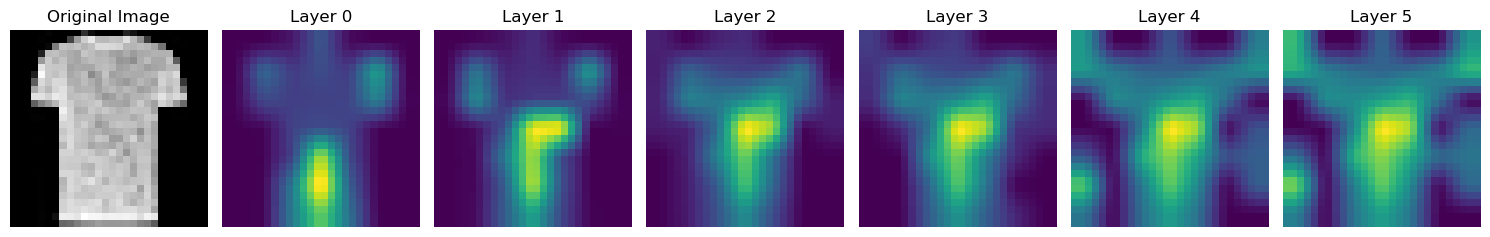

In [211]:
display_img_with_heatmap(model, img, discard_ratio=0.3, aggregate='min')

Ehh, i think this is too low. I think the 0.5 ratio was the best for this image <br> we cant try other images

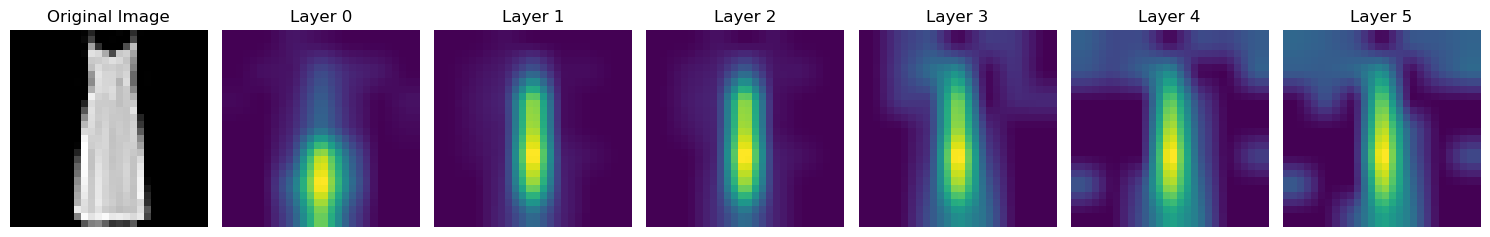

In [214]:
batch_test = next(iter(test_loader))
img = batch_test[0][13:14]
display_img_with_heatmap(model, img, discard_ratio=0.5, aggregate='min')

This also shows nice visualization, the focus is on the middle line, mainly the dress line, and it spreads out through the layers, i feel like this heat map might benefit from a higher discard ratio

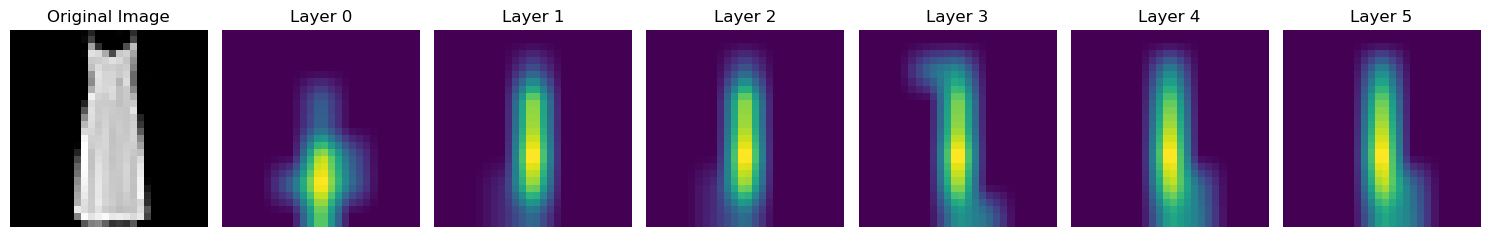

In [218]:
display_img_with_heatmap(model, img, discard_ratio=0.85, aggregate='min')

0.85 ratio for this looks really nice, only the relevant parts are shown and the residual heat is removed to make for a nice diagram<br> <br> Lets try some more images

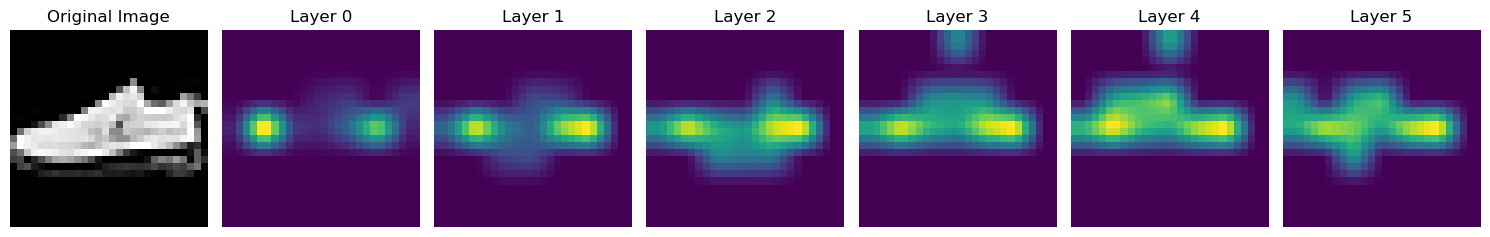

In [224]:
batch_test = next(iter(test_loader))
img = batch_test[0][38:39]
display_img_with_heatmap(model, img, discard_ratio=0.8, aggregate='min')

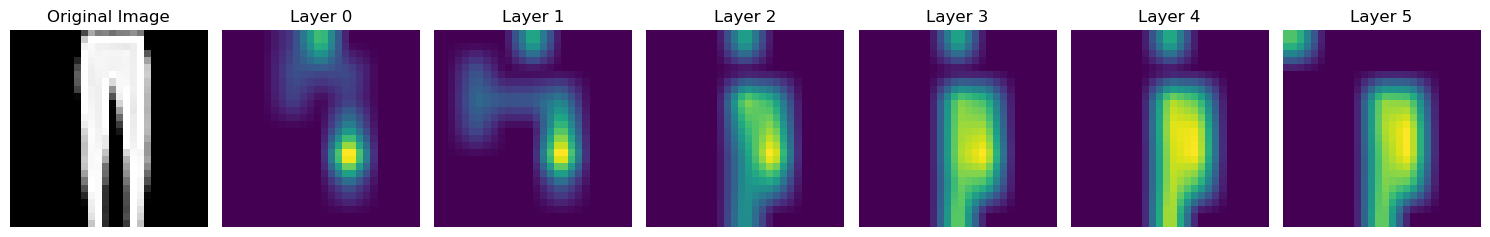

In [243]:
batch_test = next(iter(test_loader))
img = batch_test[0][41:42]
display_img_with_heatmap(model, img, discard_ratio=0.8, aggregate='min')

(I skipped the tinkering notes and just chose what i thought looked best)<br> Over all the most of the heatmaps look nice and give insight into what the ViT Model looks at when classifying, some random areas are focused on in some of the images, but overall it looks nice

### Final Notes

I increased the number of epochs(compared to the material notebook) for the training just out of curiosity and that did lead to some increase in accuracy, I am curious as to see how this will compare to trainig the CNN for the same number of epochs and see if the accuracy and time are better/worse.

## Implementation Teacher Model (CNN)

### Defining a CNN Model

We take the one provided in the earlier notebooks <a id=t311></a>

In [244]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Training the CNN model

We will be training on the same dataloaders provided for the transformer model even though we can train on larger image sizes, this is so we are able to compare the results between the 2 models. We also train for the same number of epochs <a id="t312"> </a>

In [246]:
def train_for_epochs(device, epchs, model, trainloader, optimizer, criterion, binary=True, unsqueeze=False ,save_name="teacher_model.pt"):
    # dictionary for saving history during training
    history = {
        "train": {
            "loss": [],
            "accuracy": []
        },
    }
    loop = trange(epchs)
    # Training loop
    for epoch in loop:

        epoch_loss_train, epoch_accuracy_train = train(device, model, trainloader, optimizer, criterion, binary=binary, unsqueeze=unsqueeze)   

        history["train"]["loss"].append(epoch_loss_train)
        history["train"]["accuracy"].append(epoch_accuracy_train)

        loop.set_description(f"Train Loss: {epoch_loss_train:.2f}, Train Acc: {epoch_accuracy_train:.2f}")
        
    #Saving the model    
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, save_name))

    return history

def train(device, model, dataloader, optimizer, criterion, binary=True, unsqueeze=False):
    model.train() 
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Iterate over the training dataset
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        if unsqueeze:
            labels=labels.unsqueeze(1).float()
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
         # Compute the predicted labels
        if binary:
            predicted = torch.round(outputs)
        else:
            outputs = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        # Count correct and total predictions
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    return epoch_loss, epoch_accuracy

In [247]:
model = CNN()

In [248]:
#We train for the same number of epochs
NUM_EPOCHS = EPOCHS

# Move the model weights to the desired device
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

start_train_mnist = time.time()

print(f'MNIST training started: {start_train_mnist}')
# run training, set binary to false since we have a multi label classification
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, optimizer, criterion, binary=False)

finish_train_mnist = time.time()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

MNIST training started: 1720006203.8675573


  0%|          | 0/25 [00:00<?, ?it/s]

MNIST training finished: 1720006749.987061 (duration: 546.119503736496)


This was faster then training the ViT Model, 9 mins vs 11 mins, so lets see how the accuracy and loss compares

### Evaluate and Comparison with ViT 

We made sure to train for the same number of epochs so that the comparison would be fair

In [249]:
def validate(device, model, dataloader, criterion, binary=True, unsqueeze=False):
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
     # Set the model to validation mode
    model.eval() 
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over validation set
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            if unsqueeze:
                labels=labels.unsqueeze(1).float()
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            running_loss_val += loss.item()

            # Compute the predicted labels
            if binary:
                predicted = torch.round(outputs)
            else:
                outputs = torch.softmax(outputs, 1)
                _, predicted = torch.max(outputs, 1)
            # Count correct and total predictions
            total_predictions_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()
                               

    # Calculate the average loss and accuracy
    epoch_loss_val = running_loss_val / len(dataloader)
    epoch_accuracy_val = (correct_predictions_val / total_predictions_val) * 100
    return epoch_loss_val, epoch_accuracy_val

Load the last epoch of the CNN

In [250]:
model = CNN()
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "teacher_model.pt")))
model = model.to(device)

In [251]:
train_acc = history['train']['accuracy'][-1]
_, test_acc = validate(device, model, test_loader, criterion, binary=False)
print(f'CNN: \nTrain Acc. {train_acc:.2f}\nTest Acc. {test_acc:.2f}')
print(f'ViT: \nTrain Acc. {(vit_history['train']['accuracy'][-1] * 100):.2f}\nTest Acc. {(vit_history['test']['accuracy'][-1] * 100):.2f}')

cnn_history = history

CNN: 
Train Acc. 93.25
Test Acc. 92.68
ViT: 
Train Acc. 85.11
Test Acc. 86.95


We can see that, even though the Vit model took longer to train, it has lower accuracy than the CNN model in both the test and train

Now we can draw the graph for the accuracy and loss per epoch for both models<a id="t313"> </a>

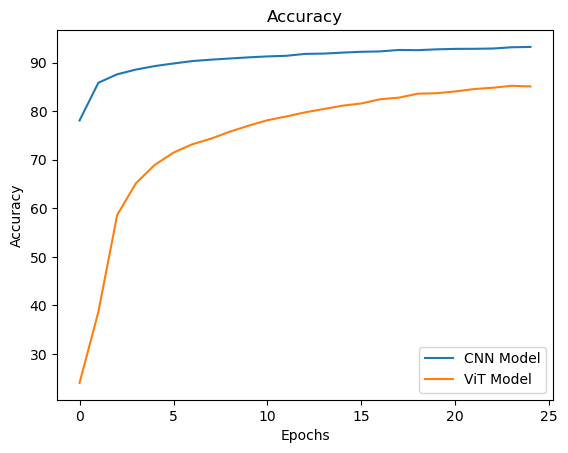

In [252]:
cnn_train_acc = cnn_history['train']['accuracy']
vit_train_acc = [i * 100 for i in vit_history['train']['accuracy']]

plt.plot(range(NUM_EPOCHS), cnn_train_acc, label='CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(range(NUM_EPOCHS), vit_train_acc, label='ViT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title("Accuracy")
plt.legend()
plt.show()

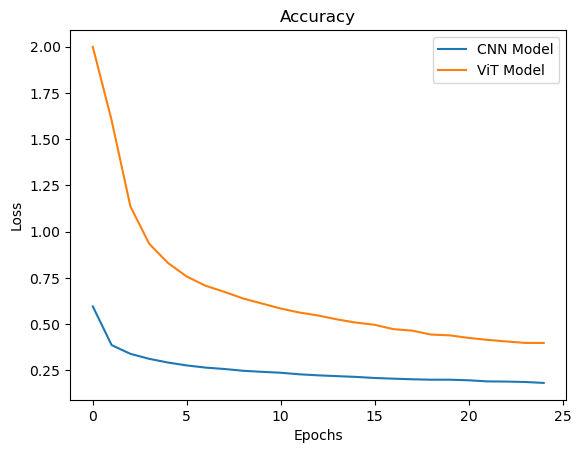

In [253]:
cnn_train_losses = cnn_history['train']['loss']
vit_train_losses = vit_history['train']['loss']


plt.plot(range(NUM_EPOCHS), cnn_train_losses, label='CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')



plt.plot(range(NUM_EPOCHS), vit_train_losses, label='ViT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.title("Accuracy")
plt.legend()
plt.show()

Oof! for both loss and accuracy, the CNN model maintains a lead over the Vit model over all epochs

And we can also display some prediction of the CNN model <a id="t314"> </a>

In [256]:
batch_test = next(iter(test_loader))
offset = 42
preds, _ = predict_batch(model, batch_test[0][offset:offset+16], binary=False)


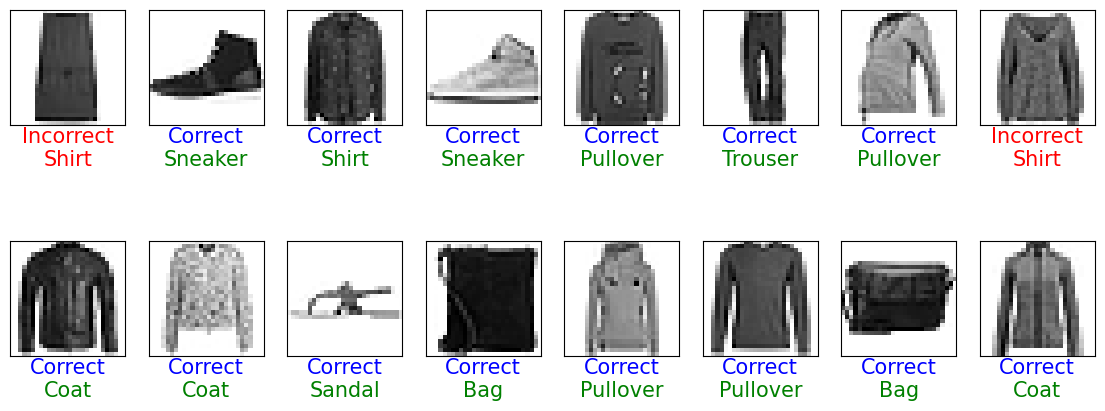

In [257]:
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(14, 5.5))
    for i in range(16):
        correct = preds[i] == batch_test[1][offset+i]
        ax = fig.add_subplot(2, 8, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][offset+i].view(28, 28)
        ax.imshow(img, cmap='gray_r')
        ax.text(0.5, -0.3, '{}'.format(labels_map[preds[i].item()]), 
                size=15, color='green' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.5, -0.1, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=15, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
plt.show()

Ye, for the same images that were displayed earlier for the Vit model, the CNN only makes 2 mistakes, compared to the 5 the Vit model made.<br>
The first img is misclassified in both, which i guess makes sense for the CNN as the resoulation downscaling make sit vaguely look like a t shirt

**My Interpetation**<br><br> 
<a id="t315"></a>
Even though the training times are equivelent, we can clearly see that the accuracy of the CNN is greater than the accuracy of the transformer. While the transformer showed better results in the study [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), we need a huge dataset (>100,000,000 datapoints) to begin to see the better accuracy from the transformer as it is a more general model, for the given dataset, we have way fewer datapoints, so the CNN proved to be better <br>
The CNN was able to achieve accuracy of 92.5 for test data while the Vit was only able to achieve 86.5 for the same number of epochs



## Implementation DeiT Model and Distilation Loss

We need to implement the Distilation loss and then modify the ViT model with the extra Distilation Token

### Distilation Loss <a id="t321"></a>

We make a class the does the Distillation loss, this was mainly based on the [provided study](https://arxiv.org/pdf/2012.12877) from facebook and its source code

In [258]:
class HardDistillationLoss(torch.nn.Module):
    def __init__(self,teacher_model, base_criterion=nn.CrossEntropyLoss() ):
        super().__init__()
        
        #We used cross entropy loss
        self.criterion = base_criterion
        
        self.teacher_model = teacher_model
    def __call__(self, input ,student_output, labels):
        
        #Cls token loss
        student_loss = self.criterion(student_output[0], labels)
        
        #calculate the teacher output for the model
        with torch.no_grad():
            teacher_output = self.teacher_model(input)
            
        #Compute the loss for the Distilation token
        teacher_loss = self.criterion(student_output[1], teacher_output.argmax(dim=1))
        
        #we do the weighted sum
        distillation_loss = (0.5 * student_loss) + (0.5 * teacher_loss)
        
        return distillation_loss

### DeiT Model

Added the distillation token here <a id="t331"></a>

In [259]:
class DeiTEmbedLayer(nn.Module):
    def __init__(self, n_channels, embed_dim, image_size, patch_size, dropout=0.0):
        super().__init__()
        # Convolutional layer to convert image patches to embeddings
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding

        # Classification token, learnable parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        
        # Distilation Token, learnable parameter
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        
        # Positional embeddings for each patch + 1 for the classification token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 2, embed_dim), requires_grad=True)  # Positional Embedding
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Convert image to patch embeddings
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)

        # Flatten the patch embeddings
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)

        # Transpose to match transformer input shape
        x = x.transpose(1, 2)  # B E S -> B S E 

        # Add classification token at the start of each sequence
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        
        # Add Distilation Token to the end of each sequence
        x = torch.cat((x, torch.repeat_interleave(self.dist_token, x.shape[0], 0)), dim=1)
        
        # Add positional embeddings
        x = x + self.pos_embedding  # Adding positional embedding
        
        # Apply dropout
        x = self.dropout(x)
        
        return x

In [260]:
class DeiTEncoder(nn.Module):
    def __init__(self, embed_dim, n_attention_heads, forward_mul, dropout=0.0):
        super().__init__()
        # Layer normalization and self-attention layer
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, n_attention_heads)
        self.dropout1 = nn.Dropout(dropout)

        # Feed-forward network layers
        self.norm2 = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_mul)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_mul, embed_dim)
        self.dropout2 = nn.Dropout(dropout)
        

    def forward(self, x):
        # Apply self-attention with skip connection
        delta_x, x_attention = self.attention(self.norm1(x))
        x = x + self.dropout1(delta_x)

        # Apply feed-forward network with skip connection
        x = x + self.dropout2(self.fc2(self.activation(self.fc1(self.norm2(x)))))
        return x, x_attention


Added the fully connected layer here <a id="t332"></a>

In [261]:
class DeiTClassifier(nn.Module):
    def __init__(self, embed_dim, n_classes):
        super().__init__()
        # Linear layers for classification
        # New architectures skip fc1 and activations and directly apply fc2.
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(embed_dim, n_classes)
        self.fc3 = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        # Use only the classification token for prediction
        dist = x[:, -1, :]
        x = x[:, 0, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        dist = self.fc3(dist)
        return (x, dist)

<a id="t333"></a>

In [262]:
def DeiT_vit_init_weights(m): 
    # Initialize weights for Conv2d and Linear layers
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    # Initialize weights for LayerNorm
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    # Initialize weights for EmbedLayer
    elif isinstance(m, EmbedLayer):
        nn.init.trunc_normal_(m.cls_token, mean=0.0, std=0.02)
        nn.init.trunc_normal_(m.pos_embedding, mean=0.0, std=0.02)
        nn.init.trunc_normal_(m.dist_token, mean=0.0, std=0.02)

In [263]:
class MyDeiT(nn.Module):
    def __init__(self, n_channels, embed_dim, n_layers, n_attention_heads, forward_mul, image_size, patch_size, n_classes, dropout=0.1):
        super().__init__()
        # Embedding layer
        self.embedding = DeiTEmbedLayer(n_channels, embed_dim, image_size, patch_size, dropout=dropout)

        # Encoder layers
        self.encoder = nn.ModuleList([DeiTEncoder(embed_dim, n_attention_heads, forward_mul, dropout=dropout) for _ in range(n_layers)])
        
        # Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier
        self.classifier = DeiTClassifier(embed_dim, n_classes)

        # Initialize weights
        self.apply(DeiT_vit_init_weights)

    #Task 2.1: Added Parameter return_attention
    def forward(self, x, return_attention=False):
        
        # Apply embedding and encoder layers
        x = self.embedding(x)
        for i, block in enumerate(self.encoder):
            x, x_attention = block(x)
            if(i > 0):
                #Task 2.1: Appending each attention matrix to each other
                x_attention_return = torch.cat((x_attention_return,x_attention),dim=0)
            else:
                x_attention_return = x_attention
        x = self.norm(x)
        x = self.classifier(x)
        if(return_attention):
            return x, x_attention_return
        return x

### Training The DeiT Model

In [264]:
# Show number of model parameters
params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} learnable parameters")   

Model has 3,274,634 learnable parameters


In [265]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [307]:
def deit_test_dataset(model,loss_fn,loader):
    # Set Vision Transformer to evaluation mode
    model.eval()

    # Arrays to record all labels and logits
    all_labels = []
    all_logits = []
    loss = 0
    # Testing loop
    for (x, y) in loader:
        x = x.cuda()
        label = y
        y = y.cuda()
        # Avoid capturing gradients in evaluation time for faster speed
        with torch.no_grad():
            logits = model(x)
            
        loss += loss_fn(x, logits ,y).item()
        
    
        all_labels.append(label)
        all_logits.append(logits[0].cpu())

    # Convert all captured variables to torch
    all_labels = torch.cat(all_labels)
    all_logits = torch.cat(all_logits)
    all_pred = all_logits.max(1)[1]
    
    #average loss per test batch    
    loss = loss/len(loader)
    # Convert all captured variables to torch
    
    
    acc = accuracy_score(y_true=all_labels, y_pred=all_pred)
    cm = confusion_matrix(y_true=all_labels, y_pred=all_pred, labels=range(N_CLASSES))

    return acc, cm, loss

def deit_test(model,loss_fn,train_loader,test_loader):
    # Test using test loader
    acc, cm, loss = deit_test_dataset(model,loss_fn,test_loader)
    print(f"Test acc: {acc:.2%}\tTest loss: {loss:.4f}")
    # Optional: print confusion matrix
    #print(cm)

    return acc, loss

We define the DeiT model with the same parameters as the Vit model defined earlier

In [267]:
model = MyDeiT(n_channels=N_CHANNELS, embed_dim=EMBED_DIM, 
                          n_layers=N_LAYERS, n_attention_heads=N_ATTENTION_HEADS, 
                          forward_mul=FORWARD_MUL, image_size=IMAGE_SIZE, 
                          patch_size=PATCH_SIZE, n_classes=N_CLASSES, dropout=DROPOUT)

model = model.to(device)

We set the previously trained CNN model as the teacher model

In [268]:
teacher_model = CNN()
teacher_model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "teacher_model.pt")))
teacher_model = teacher_model.to(device)

In [269]:
# Train
iters_per_epoch = len(train_loader)

# Define optimizer for training the model
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)

# Define loss function
loss_fn = HardDistillationLoss(teacher_model)


# scheduler for linear warmup of lr and then cosine decay
linear_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/WARMUP_EPOCHS, end_factor=1.0, total_iters=WARMUP_EPOCHS-1, last_epoch=-1)
cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-5)

# Variable to capture best test accuracy
best_acc = 0

train_start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    
    start_time = time.time()
    # Set model to training mode
    model.train()

    # Arrays to record epoch loss and accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []

    # Loop on loader
    for i, (x, y) in enumerate(train_loader):

        # Push to GPU
        x, y = x.cuda(), y.cuda()
        
        #x = x.cpu()

        # Get output logits from the model 
        logits = model(x)

        # Compute training loss
        loss = loss_fn(x, logits, y)

        # Updating the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch metrics
        batch_pred = logits[0].max(1)[1]
        batch_accuracy = (y==batch_pred).float().mean()
        train_epoch_loss += [loss.item()]
        train_epoch_accuracy += [batch_accuracy.item()]

        # Log training progress
        if i % 50 == 0 or i == (iters_per_epoch - 1):
            print(f'Ep: {epoch+1}/{EPOCHS}\tIt: {i+1}/{iters_per_epoch}\tbatch_loss: {loss:.4f}\tbatch_accuracy: {batch_accuracy:.2%}')

    end_time = time.time()

    # Print elapsed time for the epoch
    print(f"Training time for epoch {epoch} in minutes: {(end_time - start_time) / 60:.2f}")

    # Print train acc and loss
    print('------------')
    print(f"Train acc: {sum(train_epoch_accuracy)/iters_per_epoch:.2%}\tTrain loss: {sum(train_epoch_loss)/iters_per_epoch:.4f}")
    
    # Test the test set after every epoch
    test_acc, test_loss = deit_test(model,loss_fn,train_loader,test_loader)
    
    # Capture best test accuracy
    best_acc = max(test_acc, best_acc)
    print(f"Best test acc: {best_acc:.2%}")

    # Save model if accuracy improves
    if test_acc >= best_acc:
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, "DeiT_model.pt"))
        print('New model saved!\n')
    
    # Update learning rate using schedulers
    if epoch < WARMUP_EPOCHS:
        linear_warmup.step()
    else:
        cos_decay.step()

    # Update training progression metric arrays
    train_losses += [sum(train_epoch_loss)/iters_per_epoch]
    test_losses += [test_loss]
    train_accuracies += [sum(train_epoch_accuracy)/iters_per_epoch]
    test_accuracies += [test_acc]

train_end_time = time.time()

# overall training time
print(f"Overall training time in minutes: {(train_end_time - train_start_time) / 60:.2f} minutes on {device} for {EPOCHS} epochs")

Ep: 1/25	It: 1/468	batch_loss: 2.3083	batch_accuracy: 13.28%
Ep: 1/25	It: 51/468	batch_loss: 2.1511	batch_accuracy: 26.56%
Ep: 1/25	It: 101/468	batch_loss: 2.0846	batch_accuracy: 23.44%
Ep: 1/25	It: 151/468	batch_loss: 2.0505	batch_accuracy: 27.34%
Ep: 1/25	It: 201/468	batch_loss: 1.9449	batch_accuracy: 32.81%
Ep: 1/25	It: 251/468	batch_loss: 1.8541	batch_accuracy: 25.00%
Ep: 1/25	It: 301/468	batch_loss: 1.8907	batch_accuracy: 24.22%
Ep: 1/25	It: 351/468	batch_loss: 1.8485	batch_accuracy: 24.22%
Ep: 1/25	It: 401/468	batch_loss: 1.8808	batch_accuracy: 28.12%
Ep: 1/25	It: 451/468	batch_loss: 1.7797	batch_accuracy: 28.91%
Ep: 1/25	It: 468/468	batch_loss: 1.7723	batch_accuracy: 32.03%
Training time for epoch 0 in minutes: 0.42
------------
Train acc: 26.21%	Train loss: 1.9475
Test acc: 29.58%	Test loss: 1.8345
Best test acc: 29.58%
New model saved!

Ep: 2/25	It: 1/468	batch_loss: 1.7446	batch_accuracy: 34.38%
Ep: 2/25	It: 51/468	batch_loss: 1.6997	batch_accuracy: 30.47%
Ep: 2/25	It: 101/46

The model was still slower than CNN, but a bit faster than the ViT, which doesnt make sense as it should be equivalent to the ViT <br> This could be to some random factor, maybe my laptops battery was low when training the ViT and it was in power saving mode, limiting the speed of the training

In [270]:
#For later comparison
deit_history = {"train" : {"loss" : train_losses, "accuracy" : train_accuracies},
               "test" : {"loss" : test_losses, "accuracy" : test_accuracies}}

### Evalutation and Comparison With The Other Models

In [271]:
print(f'CNN: \nTrain Acc. {train_acc:.2f}\nTest Acc. {test_acc:.2f}')
print(f'ViT: \nTrain Acc. {(vit_history['train']['accuracy'][-1] * 100):.2f}\nTest Acc. {(vit_history['test']['accuracy'][-1] * 100):.2f}')
print(f'DeiT: \nTrain Acc. {(deit_history['train']['accuracy'][-1] * 100):.2f}\nTest Acc. {(deit_history['test']['accuracy'][-1] * 100):.2f}')

CNN: 
Train Acc. 93.25
Test Acc. 0.88
ViT: 
Train Acc. 85.11
Test Acc. 86.95
DeiT: 
Train Acc. 86.68
Test Acc. 88.26


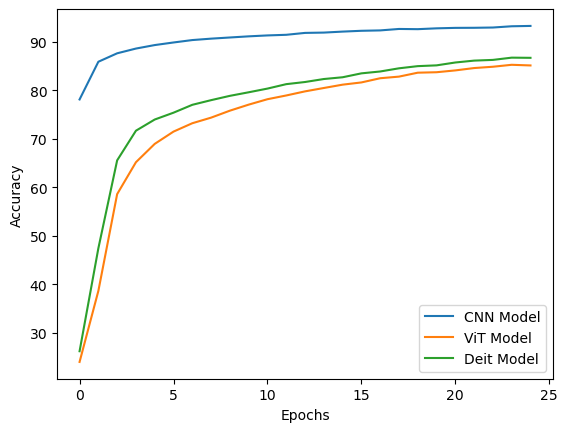

In [272]:
cnn_train_acc = cnn_history['train']['accuracy']
vit_train_acc = [i * 100 for i in vit_history['train']['accuracy']]
deit_train_acc = [i * 100 for i in deit_history['train']['accuracy']]


plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.plot(range(NUM_EPOCHS), cnn_train_acc, label='CNN Model')
plt.plot(range(NUM_EPOCHS), vit_train_acc, label='ViT Model')
plt.plot(range(NUM_EPOCHS), deit_train_acc, label='Deit Model')


plt.legend()
plt.show()

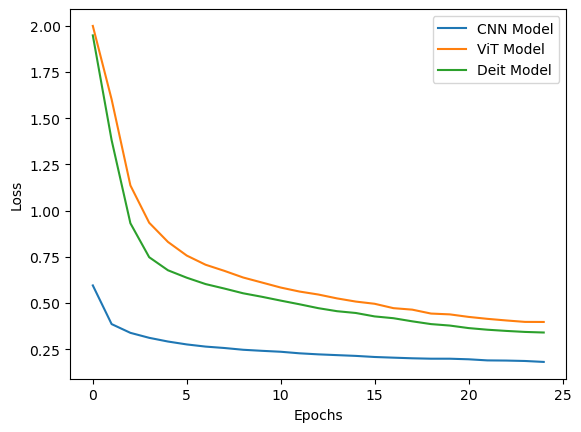

In [273]:
cnn_train_losses = cnn_history['train']['loss']
vit_train_losses = vit_history['train']['loss']
deit_train_losses = deit_history['train']['loss']


plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(range(NUM_EPOCHS), cnn_train_losses, label='CNN Model')
plt.plot(range(NUM_EPOCHS), vit_train_losses, label='ViT Model')
plt.plot(range(NUM_EPOCHS), deit_train_losses, label='Deit Model')

plt.legend()
plt.show()

So overall the Deit model provided better results in both accuracy in test and train sets, and in also the loss, This is what we expected from reading the studies, because Deit should excel in smaller datasets.

### Heatmap Visualization

To visualize he attention matrix, we need to modify the heatmap generation function a bit to work with the DeiT model, we have to remove both the CLS and Distilation tokens before displaying the heatmap

In [283]:
#Returns a heatmap for a specifice layer
def create_attention_heatmap(x_attentions, aggregate='mean', discard_ratio=0.9, layer=5):
    joint_attentions =torch.empty(6,51,51)
    joint_attentions = joint_attentions.to(device)
    for i, x_attention in enumerate(x_attentions):
        with torch.no_grad():
            x_attention
            
            #Aggregate
            match aggregate:   
                case 'min':
                    x_attention = torch.min(x_attention, dim=0).values
                case 'max':
                    x_attention = torch.max(x_attention, dim=0).values
                case 'mean':
                    x_attention = torch.mean(x_attention, dim=0)
                case _:
                    x_attention = torch.mean(x_attention, dim=0)
                
            discard_attentions = x_attention

            #Add residual connections
            I = torch.eye(discard_attentions.size(1))
            I = I.to(device)
            
            #Normalize
            discard_attentions = discard_attentions + I
            discard_attentions = discard_attentions / discard_attentions.sum(dim=-1).unsqueeze(-1)
            
            
            #Multiply previous layers
            if i == 0:
                joint_attentions[i] = discard_attentions
            else:
                joint_attentions[i] = torch.matmul(discard_attentions, joint_attentions[i-1])

    #Choose layer          
    joint_attentions_layer = joint_attentions[layer]
    
    joint_attentions_layer = joint_attentions_layer[0, 1:50]
    joint_attentions_layer = joint_attentions_layer.view(7,7)
    
    #Remove values below threshold
    threshold_value = torch.quantile(joint_attentions_layer, discard_ratio)
    joint_attentions_layer[joint_attentions_layer < threshold_value] = 0
    
    #Reshape into image size
    heatmap = F.interpolate(joint_attentions_layer.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()

    return heatmap

In [275]:
batch_test = next(iter(test_loader))
img = batch_test[0][125:126]

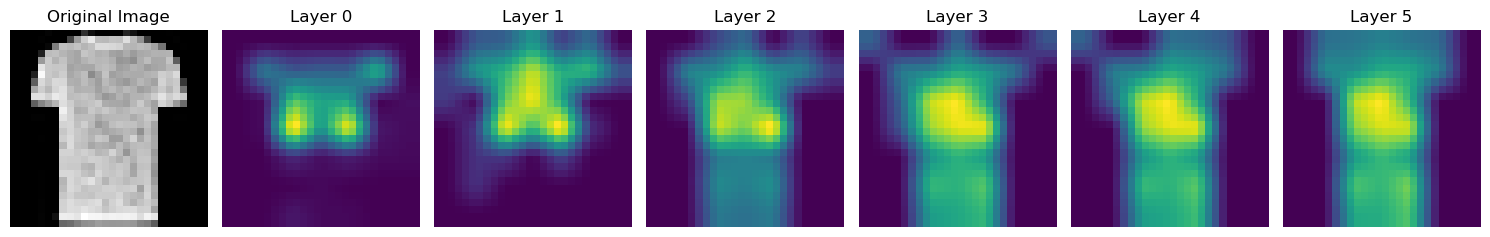

In [284]:
display_img_with_heatmap(model, img, discard_ratio=0.5, aggregate='min')

Ohh, in our opinion, This looks quite a bit more impressive than the heatmap from ViT, the focus is on all relevant areas of the tshirt, and very few random focus areas

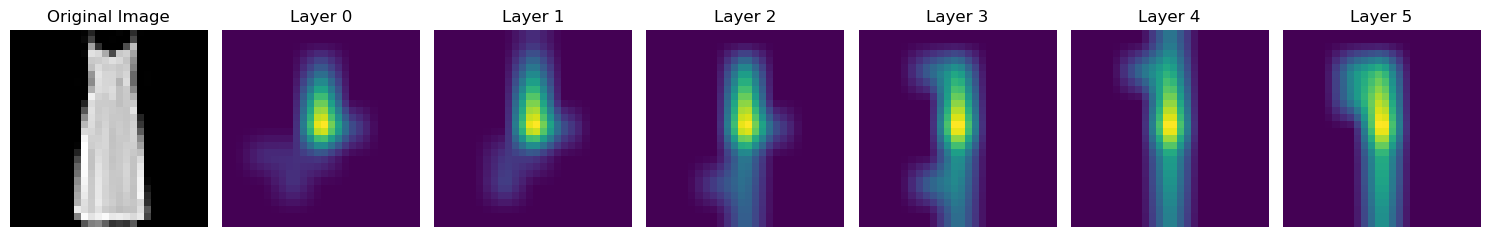

In [287]:
batch_test = next(iter(test_loader))
img = batch_test[0][13:14]
display_img_with_heatmap(model, img, discard_ratio=0.85, aggregate='min')

This one looks comparable

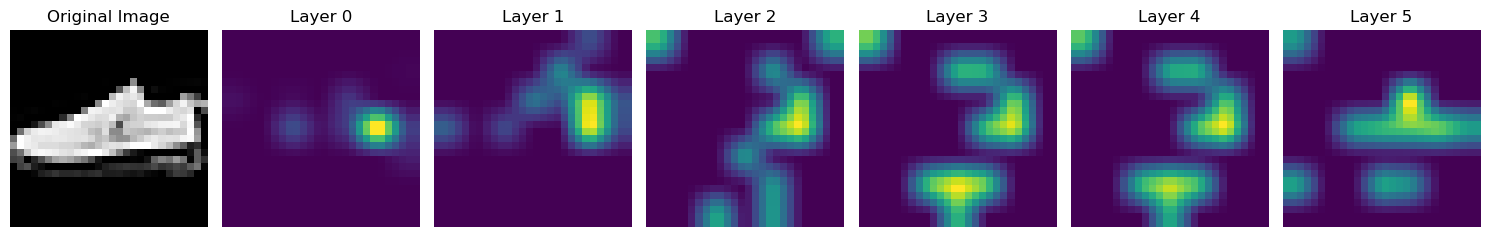

In [290]:
batch_test = next(iter(test_loader))
img = batch_test[0][38:39]
display_img_with_heatmap(model, img, discard_ratio=0.8, aggregate='min')

Ehh, this one looks worse, maybe the DeiT model used some unconventional areas to recognize the image

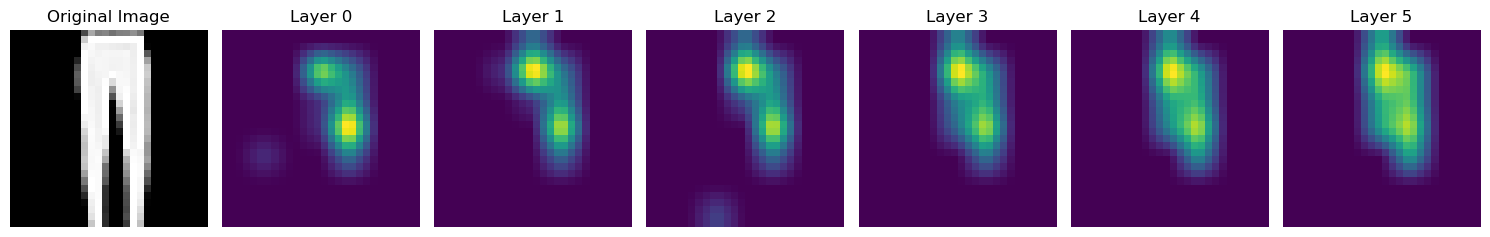

In [293]:
batch_test = next(iter(test_loader))
img = batch_test[0][41:42]
display_img_with_heatmap(model, img, discard_ratio=0.85, aggregate='min')

This one looks generally nice

<br>
<br>
* Overall I think the heatmaps look nicer here than the ones for the ViT model *

### Some thoughts
We didnt get much better results from the Deit model(Only about 1% better), even though its supposed to be better with smaller data sets, we have a few guesses as to why:
- It could be that the teacher model was not trained enough for it to provide better results when calculating the loss
- In the original studies, the ViT model was trained on a set of 300 Million images, while the DeiT was trained on 1.5 Million images and got comparable results (only a few % less accurate on img set), it could be that the number of images we used for the training is too small for the advantage of DeiT to show,
- It could also be that the models need more epochs to show the advantage of having a smaller image size
- It might be that the modifications that we did to the data set, such as decreasing the resolution, is causing there not to be enough data in the image the advantage of DeiT to show

Or it could be that the results we got are what we should have gotten, its hard to know without a reference <br><br>

So we will be training the models a bit more to see what we get from more training

## More work?

We are going to test out ideas 1 and 3 from the above, so we will train the teacher model for an extra 50 epochs, and then train the ViT and DeiT for another 50 epochs and see if that would show more expected results

We can start by continuing the training of the teacher model for 50 epochs

In [294]:
EPOCHS = 50

In [296]:
model = CNN()
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "teacher_model.pt")))

#We train for the same number of epochs
NUM_EPOCHS = EPOCHS

# Move the model weights to the desired device
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

start_train_mnist = time.time()

print(f'MNIST training started: {start_train_mnist}')
# run training, set binary to false since we have a multi label classification
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, optimizer, criterion, binary=False, save_name="teacher_model_75_epoch.pt")

finish_train_mnist = time.time()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

cnn_history = history

MNIST training started: 1720008899.078324


  0%|          | 0/50 [00:00<?, ?it/s]

MNIST training finished: 1720009972.993465 (duration: 1073.9151408672333)


Then we can train the ViT model for 50 more epochs

In [300]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model = VisionTransformer(n_channels=N_CHANNELS, embed_dim=EMBED_DIM, 
                          n_layers=N_LAYERS, n_attention_heads=N_ATTENTION_HEADS, 
                          forward_mul=FORWARD_MUL, image_size=IMAGE_SIZE, 
                          patch_size=PATCH_SIZE, n_classes=N_CLASSES, dropout=DROPOUT)
#load from epoch 25 and save under diffrent name
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "ViT_model.pt")))
model.to(device)

# Train
iters_per_epoch = len(train_loader)

# Define optimizer for training the model
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# scheduler for linear warmup of lr and then cosine decay
linear_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/WARMUP_EPOCHS, end_factor=1.0, total_iters=WARMUP_EPOCHS-1, last_epoch=-1)
cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-5)

# Variable to capture best test accuracy
best_acc = 0

train_start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    
    start_time = time.time()
    # Set model to training mode
    model.train()

    # Arrays to record epoch loss and accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []

    # Loop on loader
    for i, (x, y) in enumerate(train_loader):

        # Push to GPU
        x, y = x.cuda(), y.cuda()

        # Get output logits from the model 
        logits = model(x)

        # Compute training loss
        loss = loss_fn(logits, y)

        # Updating the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch metrics
        batch_pred = logits.max(1)[1]
        batch_accuracy = (y==batch_pred).float().mean()
        train_epoch_loss += [loss.item()]
        train_epoch_accuracy += [batch_accuracy.item()]

        # Log training progress
        if i % 50 == 0 or i == (iters_per_epoch - 1):
            print(f'Ep: {epoch+1}/{EPOCHS}\tIt: {i+1}/{iters_per_epoch}\tbatch_loss: {loss:.4f}\tbatch_accuracy: {batch_accuracy:.2%}')

    end_time = time.time()

    # Print elapsed time for the epoch
    print(f"Training time for epoch {epoch} in minutes: {(end_time - start_time) / 60:.2f}")

    # Print train acc and loss
    print('------------')
    print(f"Train acc: {sum(train_epoch_accuracy)/iters_per_epoch:.2%}\tTrain loss: {sum(train_epoch_loss)/iters_per_epoch:.4f}")
    
    # Test the test set after every epoch
    test_acc, test_loss = test(model,loss_fn,train_loader,test_loader)
    
    # Capture best test accuracy
    best_acc = max(test_acc, best_acc)
    print(f"Best test acc: {best_acc:.2%}")

    # Save model if accuracy improves
    if test_acc >= best_acc:
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, "ViT_model_75_epoch.pt"))
        print('New model saved!\n')
    
    # Update learning rate using schedulers
    if epoch < WARMUP_EPOCHS:
        linear_warmup.step()
    else:
        cos_decay.step()

    # Update training progression metric arrays
    train_losses += [sum(train_epoch_loss)/iters_per_epoch]
    test_losses += [test_loss]
    train_accuracies += [sum(train_epoch_accuracy)/iters_per_epoch]
    test_accuracies += [test_acc]

train_end_time = time.time()

# overall training time
print(f"Overall training time in minutes: {(train_end_time - train_start_time) / 60:.2f} minutes on {device} for {EPOCHS} epochs")

vit_history = {"train" : {"loss" : train_losses, "accuracy" : train_accuracies},
               "test" : {"loss" : test_losses, "accuracy" : test_accuracies}}

Ep: 1/50	It: 1/468	batch_loss: 0.4235	batch_accuracy: 87.50%
Ep: 1/50	It: 51/468	batch_loss: 0.2777	batch_accuracy: 92.19%
Ep: 1/50	It: 101/468	batch_loss: 0.3911	batch_accuracy: 84.38%
Ep: 1/50	It: 151/468	batch_loss: 0.3620	batch_accuracy: 86.72%
Ep: 1/50	It: 201/468	batch_loss: 0.4597	batch_accuracy: 82.03%
Ep: 1/50	It: 251/468	batch_loss: 0.4801	batch_accuracy: 82.81%
Ep: 1/50	It: 301/468	batch_loss: 0.3727	batch_accuracy: 83.59%
Ep: 1/50	It: 351/468	batch_loss: 0.3692	batch_accuracy: 84.38%
Ep: 1/50	It: 401/468	batch_loss: 0.5039	batch_accuracy: 78.91%
Ep: 1/50	It: 451/468	batch_loss: 0.4382	batch_accuracy: 83.59%
Ep: 1/50	It: 468/468	batch_loss: 0.4998	batch_accuracy: 83.59%
Training time for epoch 0 in minutes: 0.42
------------
Train acc: 85.08%	Train loss: 0.4032
Test acc: 86.64%	Test loss: 0.3656
Best test acc: 86.64%
New model saved!

Ep: 2/50	It: 1/468	batch_loss: 0.4009	batch_accuracy: 86.72%
Ep: 2/50	It: 51/468	batch_loss: 0.3769	batch_accuracy: 85.94%
Ep: 2/50	It: 101/46

Then we train the DeiT model for 50 epochs, here we are using the more accurate teacher model

In [308]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model = MyDeiT(n_channels=N_CHANNELS, embed_dim=EMBED_DIM, 
                          n_layers=N_LAYERS, n_attention_heads=N_ATTENTION_HEADS, 
                          forward_mul=FORWARD_MUL, image_size=IMAGE_SIZE, 
                          patch_size=PATCH_SIZE, n_classes=N_CLASSES, dropout=DROPOUT)



model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "DeiT_model.pt")))
model = model.to(device)

teacher_model = CNN()
teacher_model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "teacher_model_75_epoch.pt")))
teacher_model = teacher_model.to(device)

# Train
iters_per_epoch = len(train_loader)

# Define optimizer for training the model
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)

# Define loss function
loss_fn = HardDistillationLoss(teacher_model)


# scheduler for linear warmup of lr and then cosine decay
linear_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/WARMUP_EPOCHS, end_factor=1.0, total_iters=WARMUP_EPOCHS-1, last_epoch=-1)
cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-5)

# Variable to capture best test accuracy
best_acc = 0

train_start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    
    start_time = time.time()
    # Set model to training mode
    model.train()

    # Arrays to record epoch loss and accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []

    # Loop on loader
    for i, (x, y) in enumerate(train_loader):

        # Push to GPU
        x, y = x.cuda(), y.cuda()
        
        #x = x.cpu()

        # Get output logits from the model 
        logits = model(x)

        # Compute training loss
        loss = loss_fn(x, logits, y)

        # Updating the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch metrics
        batch_pred = logits[0].max(1)[1]
        batch_accuracy = (y==batch_pred).float().mean()
        train_epoch_loss += [loss.item()]
        train_epoch_accuracy += [batch_accuracy.item()]

        # Log training progress
        if i % 50 == 0 or i == (iters_per_epoch - 1):
            print(f'Ep: {epoch+1}/{EPOCHS}\tIt: {i+1}/{iters_per_epoch}\tbatch_loss: {loss:.4f}\tbatch_accuracy: {batch_accuracy:.2%}')

    end_time = time.time()

    # Print elapsed time for the epoch
    print(f"Training time for epoch {epoch} in minutes: {(end_time - start_time) / 60:.2f}")

    # Print train acc and loss
    print('------------')
    print(f"Train acc: {sum(train_epoch_accuracy)/iters_per_epoch:.2%}\tTrain loss: {sum(train_epoch_loss)/iters_per_epoch:.4f}")
    
    # Test the test set after every epoch
    test_acc, test_loss = deit_test(model,loss_fn,train_loader,test_loader)
    
    # Capture best test accuracy
    best_acc = max(test_acc, best_acc)
    print(f"Best test acc: {best_acc:.2%}")

    # Save model if accuracy improves
    if test_acc >= best_acc:
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, "DeiT_model_75_epoch.pt"))
        print('New model saved!\n')
    
    # Update learning rate using schedulers
    if epoch < WARMUP_EPOCHS:
        linear_warmup.step()
    else:
        cos_decay.step()

    # Update training progression metric arrays
    train_losses += [sum(train_epoch_loss)/iters_per_epoch]
    test_losses += [test_loss]
    train_accuracies += [sum(train_epoch_accuracy)/iters_per_epoch]
    test_accuracies += [test_acc]

train_end_time = time.time()

# overall training time
print(f"Overall training time in minutes: {(train_end_time - train_start_time) / 60:.2f} minutes on {device} for {EPOCHS} epochs")

#For later comparison
deit_history = {"train" : {"loss" : train_losses, "accuracy" : train_accuracies},
               "test" : {"loss" : test_losses, "accuracy" : test_accuracies}}

Ep: 1/50	It: 1/468	batch_loss: 0.4655	batch_accuracy: 82.03%
Ep: 1/50	It: 51/468	batch_loss: 0.2189	batch_accuracy: 91.41%
Ep: 1/50	It: 101/468	batch_loss: 0.3584	batch_accuracy: 87.50%
Ep: 1/50	It: 151/468	batch_loss: 0.4285	batch_accuracy: 87.50%
Ep: 1/50	It: 201/468	batch_loss: 0.2160	batch_accuracy: 92.97%
Ep: 1/50	It: 251/468	batch_loss: 0.3544	batch_accuracy: 89.84%
Ep: 1/50	It: 301/468	batch_loss: 0.3339	batch_accuracy: 87.50%
Ep: 1/50	It: 351/468	batch_loss: 0.3680	batch_accuracy: 86.72%
Ep: 1/50	It: 401/468	batch_loss: 0.3391	batch_accuracy: 88.28%
Ep: 1/50	It: 451/468	batch_loss: 0.3044	batch_accuracy: 88.28%
Ep: 1/50	It: 468/468	batch_loss: 0.3308	batch_accuracy: 86.72%
Training time for epoch 0 in minutes: 0.43
------------
Train acc: 86.50%	Train loss: 0.3565
Test acc: 87.84%	Test loss: 0.3215
Best test acc: 87.84%
New model saved!

Ep: 2/50	It: 1/468	batch_loss: 0.2894	batch_accuracy: 89.84%
Ep: 2/50	It: 51/468	batch_loss: 0.3957	batch_accuracy: 85.16%
Ep: 2/50	It: 101/46

Now we can compare the accuracies and loss of all models

In [343]:
print(f'CNN: \nTrain Acc. {train_acc:.2f}\nTest Acc. {test_acc:.2f}')
print(f'ViT: \nTrain Acc. {(vit_history['train']['accuracy'][-1] * 100):.2f}\nTest Acc. {(vit_history['test']['accuracy'][-1] * 100):.2f}')
print(f'DeiT: \nTrain Acc. {(deit_history['train']['accuracy'][-1] * 100):.2f}\nTest Acc. {(deit_history['test']['accuracy'][-1] * 100):.2f}')

CNN: 
Train Acc. 93.25
Test Acc. 0.91
ViT: 
Train Acc. 89.25
Test Acc. 90.17
DeiT: 
Train Acc. 90.02
Test Acc. 90.89


The CNN remains the best interms of accuracy, but both the ViT and DeiT models are approaching it in test accuracy. The Deit model is still better than the ViT model, within the range of 1% still

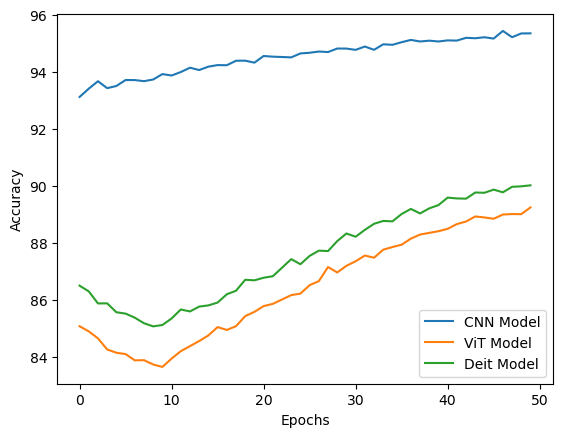

In [344]:
cnn_train_acc = cnn_history['train']['accuracy']
vit_train_acc = [i * 100 for i in vit_history['train']['accuracy']]
deit_train_acc = [i * 100 for i in deit_history['train']['accuracy']]


plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.plot(range(NUM_EPOCHS), cnn_train_acc, label='CNN Model')
plt.plot(range(NUM_EPOCHS), vit_train_acc, label='ViT Model')
plt.plot(range(NUM_EPOCHS), deit_train_acc, label='Deit Model')


plt.legend()
plt.show()

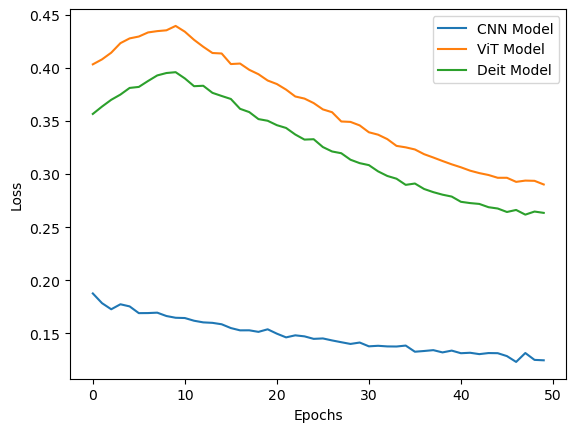

In [345]:
cnn_train_losses = cnn_history['train']['loss']
vit_train_losses = vit_history['train']['loss']
deit_train_losses = deit_history['train']['loss']


plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(range(NUM_EPOCHS), cnn_train_losses, label='CNN Model')
plt.plot(range(NUM_EPOCHS), vit_train_losses, label='ViT Model')
plt.plot(range(NUM_EPOCHS), deit_train_losses, label='Deit Model')

plt.legend()
plt.show()

The loss and accuracy are both getting worse for the first 10 epochs for DeiT, we were confused at the start but then remembered that the warmup epochs was not reset for this training, so it affected the first few epochs.<br><br> We see a similar pattern to the earlier training, the Deit model is better in both loss and accuracy by a consistant margin over the ViT model, and both are still behind the CNN, and the further training didnt see to give the DeiT model a larger advantage over the ViT. <br> Mayben more training?? ...This is enough for now

## Overall Final Notes

We were able to get the result that the DeiT model gets higher accuracies quicker on smaller data sets, The original study for ViT does training on 300 million images, while the Deit does it on around 1 million and it took 3 days of training on a normal computer and got results comparable to other model, which is quite impressive!
<br><br>
This miniproject was very interesting and quite informative, we learned alot and are happy with the final results we got! 